# Assignment: 2D radioactive lighthouse location using MCMC

As before, a radioactive source that emits gamma rays randomly in time but uniformly in angle is placed at $(x_0, y_0)$.  The gamma rays are detected on the $x$-axis and these positions are saved, $x_k$, $k=1,2,\cdots, N$.  Given these observed positions, the problem is to estimate the location of the source.

Unlike before, we will not assume that $y_0$ is known. Your task is to estimate both $x_0$ and $y_0$.  Since we are using Bayesian methods, this means finding the joint posterior for $x_0$ and $y_0$, given the data on where the gamma rays were detected.

You will combine the results and Python code from the `radioactive_lighthouse_exercise.ipynb` and `parameter_estimation_Gaussian_noise.ipynb` notebooks, sampling the posterior using `emcee` and plotting it using `corner`.


## Learning goals:

* Be able to re-use markdown and Python from existing notebooks to perform similar tasks (even if not understanding all details); e.g., generating data, sampling via MCMC, making plots.
* Successfully apply the basic ideas of Bayesian statistics: Bayes theorem, priors, sampling of posteriors.
* Successfully analyze results (with hints).
* Try out markdown.

Note: you shouldn't need to recalculate anything; focus on the notebook ingredients.

## Expressions

The posterior we want is:

$$ p(x_0, y_0 | \{x_k\}, I) {=} \frac{(p(\{x_k\} | x_0, y_0 , I)p(x_0, y_0 | I))}{p(x_k | I)}
$$

**The probability of $x_0$ and $y_0$ given data $\{x_k\}$ and the value of *I*. I being information obtained.**

*Using $\LaTeX$, fill in the right side of the equation for Bayes' rule as it applies in this case.* 

*Then add below the expression for the likelihood in this case (replace the dots with the correct form and fill in the right side):*

$$  p(\{x_k\} | x_0, y_0) = \prod_{k=1}^{N} p(x_k|x_0,y_0)
$$


*Describe in words what you will use for the prior:* 

Our prior would use $x_0$ and $y_0$ to estimate them both. There for both the $x_0$ and $y_0$ would be independent of each other. We would also set limits for both $x_0$ and $y_0$. For $x_0$ the limits could be negative or positive integer. $y_0$ can only be a positive integer. **The probability of $x_0$ and $y_0$ given data $\{x_k\}$ which would be I the information we know.**

*Do you need to find an expression for the denominator pdf?  Explain.*

No, but the expression fpr the denominator would be a normalization factor. It would probably changes the scale and not the shape, and look like something below.

$$ \int p(x_0 | \{x_k\}, y_0)\, dx_0)$$

## Python imports

You will need to import emcee and corner.  The best way to do this is to follow the instructions for making an environment (see Carmen page).  An alternative is to install them separately using (at the command line): (Install in order)

`conda install -c astropy corner`

`conda install -c astropy emcee`

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()      
sns.set_context("talk")
import numpy as np
import scipy.stats as stats
from scipy.stats import cauchy, uniform
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from scipy.stats import norm, uniform
import seaborn as sbn
sbn.set_style('white')
sbn.set_context('talk')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Generating the data

Copy-and-paste here the code from `radioactive_lighthouse_exercise.ipynb` used to generate the $x_k$ points.  Note that you have control over where the true position is but also the size of the dataset.  You will want to adjust both later. It is recommended to add the code that plots the distribution of the data (to verify it is the same as before), but this is not required.

maximum =  630.5977396191768
minimum =  -1269.0604084839229


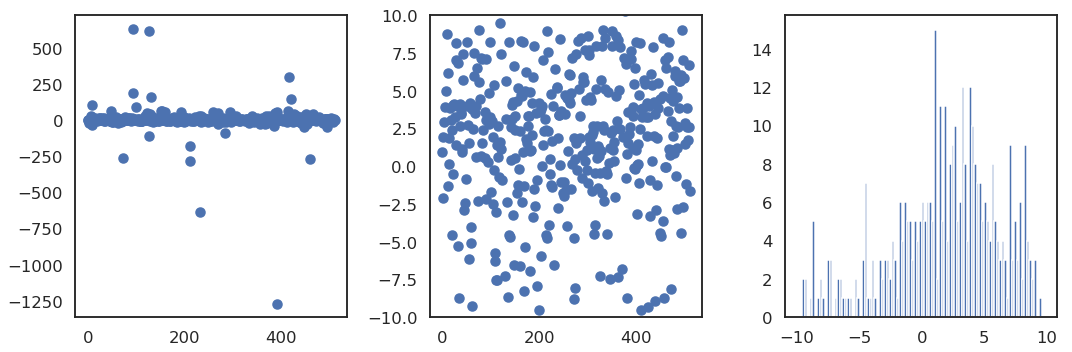

In [174]:
# True location of the radioactive source
x0_true = 3.
y0_true = 4.

# Generate num_pts random numbers distributed according to dist and plot 
num_pts = 512
x_pts = np.arange(num_pts)

# Distribution knowing where the source is: scipy.stats.cauchy(loc, scale)
dist = cauchy(x0_true, y0_true)
dist_pts = dist.rvs(num_pts)  

# Make some plots!
fig = plt.figure(figsize=(15,5))

# First plot all the points, letting it autoscale the counts
ax_1 = fig.add_subplot(1,3,1)
ax_1.scatter(x_pts, dist_pts)  

# Repeat but zoom in to near the origin
ax_2 = fig.add_subplot(1,3,2)
ax_2.scatter(x_pts, dist_pts)
ax_2.set_ylim(-10.,10.)

# Finally make a zoomed-in histogram
ax_3 = fig.add_subplot(1,3,3)
out = ax_3.hist(dist_pts, bins=np.arange(-10., 10., 0.2))

# Print out the numerical limits (max and min)
print('maximum = ', np.amax(dist_pts))
print('minimum = ', np.amin(dist_pts))

fig.tight_layout()

## PDFs for applying Bayes' rule

*Adapt code from the two notebooks to express the logarithms of the prior, likelihood, and posterior for this case.*

In [175]:
min_theta=np.array([-4,0.1])
max_theta=np.array([4,10])
volume_theta=np.prod(max_theta-min_theta)

def log_prior(theta):
    '''Log prior for parameter array theta'''
    assert len(theta)==2, "Parameter vector must have length two."
    # flat prior 
    if np.logical_and(min_theta<=theta, theta<=max_theta).all(): 
        return np.log(1/volume_theta)
    else:
        return -np.inf

def log_likelihood(theta, dist_pts): 
    """
    Log likelihood for the first N_max points of the dist_pts array,
    assuming independent.  Not normalized!  
    """
    (x0,y0) = theta
    D_pts = (np.log((np.abs(y0)/np.pi)*(1/(((y0)**2)+((dist_pts-x0)**2)))))
    return sum(D_pts)
    
def log_posterior(theta, X):
    '''Log posterior for data X given parameter array theta'''
    return log_prior(theta) + log_likelihood(theta, X)

## Run MCMC

*Copy code to run `emcee` and make any necessary changes.*

In [176]:
# Add the code to run emcee
# Note: D should be our dist_pts
import emcee
import corner
print('emcee sampling (version: )', emcee.__version__)


ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take

# we'll start at random locations within the prior volume
starting_guesses = min_theta + \
                   (max_theta - min_theta) * np.random.rand(nwalkers,ndim)

#print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[dist_pts])

# "burn-in" period; save final positions and then reset
pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
sampler.reset()

# sampling period
sampler.run_mcmc(pos, nsteps)

print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

emcee sampling (version: ) 2.2.1
Mean acceptance fraction: 0.720 (in total 50000 steps)


## Generate figures

Note: you do not need to do the maximum likelihood estimates that were added to the corner plot for the Gaussian noise case.  You can skip that part of the code.

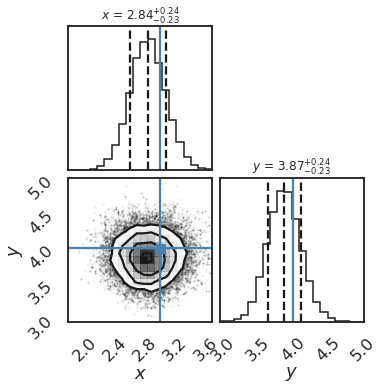

In [177]:
# Add the code to make a corner plot
# make a corner plot with the posterior distribution
fig = corner.corner(samples, labels=["$x$", "$y$"],
                    truths=[x0_true, y0_true],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

# With some manual efforts, we can add the maximum-likelihood estimate from 
#  the frequentist analysis.           
#maxlike_results = (mu_est,sigma_est)

# First, extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

## Analysis

Summarize the results for the following investigations.  You can simply add to the cell containing the questions or else start new cells.

1. *Run the notebook 10 times (which will generate 10 different sets of random data).  Record the values of $x_0$ and $y_0$ and their uncertainties given on the corner plot for each run.  Is the actual spread of values consistent with the given uncertainties?* <br/><br/>

$x_0$|Uncertainties of $x_0$|$y_0$| Uncertainties of $y_0$
---|---|---|---
2.93|+0.25, -0.24|3.92|+0.25, -0.24
3.03|+0.24, -0.24|3.96|+0.25, -0.24
2.91|+0.23, -0.23|3.68|+0.23, -0.21
3.16|+0.24, -0.24|3.85|+0.24, -0.23
2.78|+0.24, -0.24|3.69|+0.23, -0.21
2.90|+0.26, -0.26|4.21|+0.27, -0.25
2.46|+0.26, -0.27|4.30|+0.28, -0.26
2.51|+0.25, -0.25|4.08|+0.26, -0.24
3.26|+0.26, -0.27|4.10|+0.25, -0.24
2.72|+0.25, -0.26|4.25|+0.28, -0.27

NOTE: my values of x and y trues are different

For the value of y0, the spread of values is consistent with the given uncertainties. But the x0 values are not in the spread values as much. 

2. *Increase the number of data points by a factor of 10.  By how much does the width of the posterior shrink?  Is this expected?* <br/><br/>

The width does shift. This should be expected we have more points to account for. The width of the posterior shrunk by what looks like 0.35 on one side and 0.70 on the other. 

3. *What does increasing the number of MC steps per walker do?* <br/><br/>

This should increase the number of points the each walker has. There for increase the number of points. This is evident when you look on the outer most contour line. <br/><br/>

4. *Try changing `x0_true` and `y0_true`.  Does it still work?* <br/><br/>

Yes, the code still works. <br/><br/>